In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
data_path = './3rd-ml100marathon-midterm/'
df_train = pd.read_csv(data_path + 'train_data.csv')
df_test = pd.read_csv(data_path + 'test_features.csv')
print(df_train.shape)
print(df_test.shape)

(113, 22)
(33, 21)


In [3]:
# 重組資料成為訓練 / 預測用格式

# poi 這個 column 是只有 train set 才有的 (label)
train_Y = df_train['poi'].values
df_train = df_train.drop(['poi'] , axis=1) #將 column = 'poi' drop 出來
train_num = df_train.shape[0]

df = pd.concat([df_train, df_test])
df = df.drop(['name'], axis=1)
print(df.shape)
df.head(10)

(146, 20)


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0
5,NaN,10259.0,NaN,NaN,joe.hirko@enron.com,30766064.0,77978.0,NaN,NaN,NaN,NaN,NaN,2856.0,NaN,NaN,NaN,NaN,NaN,91093.0,30766064.0
6,NaN,NaN,NaN,NaN,scott.yeager@enron.com,8308552.0,53947.0,NaN,NaN,NaN,NaN,NaN,147950.0,3576206.0,NaN,158403.0,NaN,NaN,360300.0,11884758.0
7,1200000.0,27610.0,-144062.0,NaN,wes.colwell@enron.com,NaN,16514.0,40.0,240.0,11.0,NaN,NaN,101740.0,698242.0,NaN,288542.0,1132.0,1758.0,1490344.0,698242.0
8,7000000.0,202911.0,-300000.0,NaN,kenneth.lay@enron.com,34348384.0,99832.0,36.0,123.0,16.0,81525000.0,3600000.0,10359729.0,14761694.0,NaN,1072321.0,2411.0,4273.0,103559793.0,49110078.0
9,600000.0,NaN,NaN,NaN,ben.glisan@enron.com,384728.0,125978.0,16.0,52.0,6.0,NaN,71023.0,200308.0,393818.0,NaN,274975.0,874.0,873.0,1272284.0,778546.0


### 處理異常欄位
* 有太多Nan的欄位，整欄不使用

In [4]:
print(df.columns)
ratio = 0.55
selected_columns = [] #只留下 非 NaN 值比率大於 ratio 的 columns 
for col in df.columns:
    if (((~df_train[col].isnull()).values.sum())/df.shape[0] > ratio):
        selected_columns.append(col)
print(selected_columns)
df = df[selected_columns]

Index(['bonus', 'deferral_payments', 'deferred_income', 'director_fees',
       'email_address', 'exercised_stock_options', 'expenses', 'from_messages',
       'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances',
       'long_term_incentive', 'other', 'restricted_stock',
       'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
       'to_messages', 'total_payments', 'total_stock_value'],
      dtype='object')
['email_address', 'exercised_stock_options', 'restricted_stock', 'total_payments', 'total_stock_value']


In [5]:
#確定只有 int64, float64, object 三種類型後, 分別將欄位名稱存於三個 list 中
int_features = []
float_features = []
object_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

0 Integer Features : []

4 Float Features : ['exercised_stock_options', 'restricted_stock', 'total_payments', 'total_stock_value']

1 Object Features : ['email_address']


### Category Encoding

In [6]:
#name 是key 所以不處理
#對 email_address 做 LabelEncoder

df['email_address'] = df['email_address'].fillna('None')
df['email_address'] = LabelEncoder().fit_transform(df['email_address'])

In [7]:
df.head(10)

,email_address,exercised_stock_options,restricted_stock,total_payments,total_stock_value
0,56,19794175.0,2748364.0,505050.0,22542539.0
1,36,19250000.0,6843672.0,8682716.0,26093672.0
2,83,1624396.0,869220.0,2003885.0,2493616.0
3,73,NaN,985032.0,2652612.0,985032.0
4,10,NaN,126027.0,1639297.0,126027.0
5,45,30766064.0,NaN,91093.0,30766064.0
6,98,8308552.0,3576206.0,360300.0,11884758.0
7,111,NaN,698242.0,1490344.0,698242.0
8,57,34348384.0,14761694.0,103559793.0,49110078.0
9,4,384728.0,393818.0,1272284.0,778546.0


### 觀察每個 Float 欄位的分佈

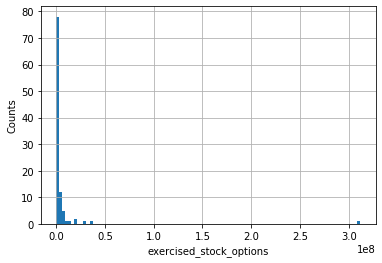

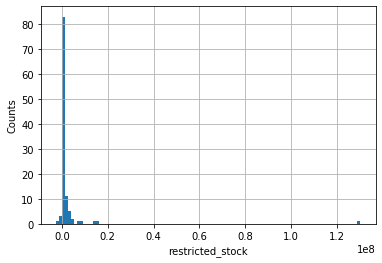

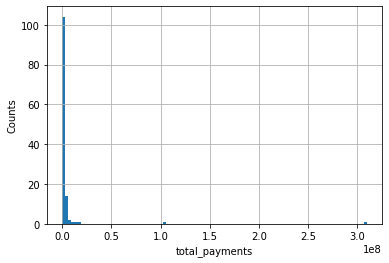

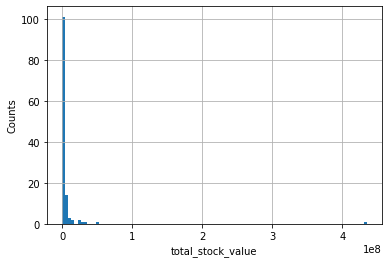

In [8]:
#畫出每個 Float Feature 的分布

ncols = 1;
nrows = len(float_features)
ind = 0
for f in float_features:
    plt.figure(num=ind)
    ind += 1
    s_tmp = df[f][(~df[f].isnull())] #拿非NaN 的來算統計    
    s_tmp.hist(bins = 100)
    plt.ylabel('Counts')
    plt.xlabel(f)
plt.show() 

### 處理 Outlier

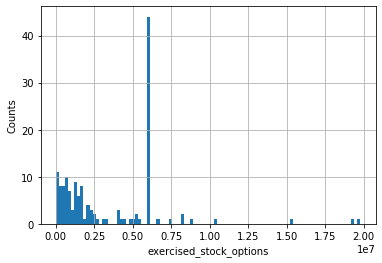

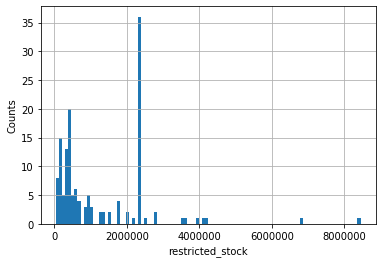

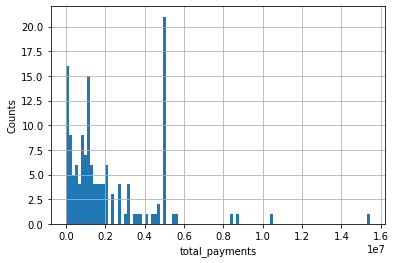

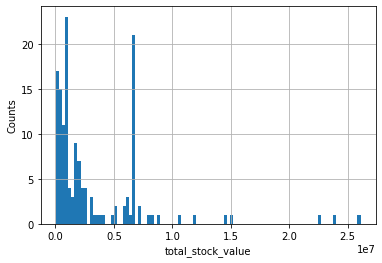

In [9]:
#對於每個 Float Feature 的分布，去除篇移值(用中位數替代)

ncols = 1;
nrows = len(float_features)
ind = 0
for f in float_features:
    plt.figure(num=ind)
    ind += 1
    s_tmp = df[f][(~df[f].isnull())] #拿非NaN 的來算統計
    md = s_tmp.median()
    mean = s_tmp.mean()
    new_series = df[f].copy()
#     new_series[df[f].isnull()] = md #nan 值用中位數取代
    new_series[df[f].isnull()] = mean #nan 值用mean取代

    
    thr_u = s_tmp.quantile(0.98) #upper 
    thr_l = s_tmp.quantile(0.02) #lower
    new_series[new_series>thr_u] = md 
    new_series[new_series<thr_l] = md

    
    
    new_series.hist(bins = 100)
    plt.ylabel('Counts')
    plt.xlabel(f)
    
    df[f] = new_series #將處理後的 Series 塞回去原本的 DataFrame
plt.show() 

In [10]:
df.head(10)

,email_address,exercised_stock_options,restricted_stock,total_payments,total_stock_value
0,56,1.979418e+07,2.748364e+06,505050.0,22542539.0
1,36,1.925000e+07,6.843672e+06,8682716.0,26093672.0
2,83,1.624396e+06,8.692200e+05,2003885.0,2493616.0
3,73,5.987054e+06,9.850320e+05,2652612.0,985032.0
4,10,5.987054e+06,1.260270e+05,1639297.0,126027.0
5,45,1.310814e+06,2.321741e+06,91093.0,1102872.5
6,98,8.308552e+06,3.576206e+06,360300.0,11884758.0
7,111,5.987054e+06,6.982420e+05,1490344.0,698242.0
8,57,1.310814e+06,4.517400e+05,1101393.0,1102872.5
9,4,3.847280e+05,3.938180e+05,1272284.0,778546.0


### Traning  (baseline)
* Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [12]:
# 13 = 3 + 3 + 3 + 4  (positive)
# 100 = 25 + 25 + 25 + 25 (negative)
# 建立 indicate set

ind_1 = np.zeros((113), dtype=bool)
start_ind = 13 #開始 negative
for i in range(3):
    ind_1[i] = True;
for i in range(start_ind, start_ind+25):
    ind_1[i] = True
    
ind_2 = np.zeros((113), dtype=bool)
start_ind = 13 #開始 negative
for i in range(3, 6):
    ind_2[i] = True;
for i in range(start_ind+25, start_ind+50):
    ind_2[i] = True;
    
ind_3 = np.zeros((113), dtype=bool)
start_ind = 13 #開始 negative
for i in range(6, 9):
    ind_3[i] = True;
for i in range(start_ind+50, start_ind+75):
    ind_3[i] = True;

ind_4 = np.zeros((113), dtype=bool)
start_ind = 13 #開始 negative
for i in range(9, 13):
    ind_4[i] = True;
for i in range(start_ind+75, start_ind+100):
    ind_4[i] = True;

In [13]:
indices = [ind_1, ind_2, ind_3, ind_4]
for i in range(len(indices)):
    print('i=%d \n'%i, indices[i])

i=0 
 [ True  True  True False False False False False False False False False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
i=1 
 [False False False  True  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True 

In [14]:
log_reg  = LogisticRegression(solver='newton-cg')

train_X = df[:train_num].values


# Cross Validation  (K-fold)
acc = 0
# 訓練模型
for i in range(len(indices)):
    train_ind = ~indices[i]
    test_ind = indices[i]
    train_X_i = train_X[train_ind]
    train_Y_i = train_Y[train_ind]
    log_reg.fit(train_X_i, train_Y_i)

    x_test_i = train_X[test_ind] #取 df 後半段為 test
    y_test_i = train_Y[test_ind]
    y_pred_i = log_reg.predict(x_test_i)
    acc_i = metrics.accuracy_score(y_test_i, y_pred_i)
    acc += acc_i/len(indices)
print("Accuracy: ", acc)

# # 預測測試集
#注意 logistic regression 的預測輸出，第一個column 是 0 的機率，第二個 column 是 1 的機率




c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimiz

Accuracy:  0.8851600985221675


c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimiz

In [15]:
#拿全部的資料來 Train
log_reg.fit(train_X, train_Y)
y_pred = log_reg.predict(train_X)
acc = metrics.accuracy_score(y_pred, train_Y)
print('acc = %.5f '%acc)

acc = 0.89381 


c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\raoblack\documents\python_env\100ai\lib\site-packages\scipy\optimiz

### 建立Kaggle submission

In [16]:
test_X = df[train_num:].values
y_pred_prob = log_reg.predict_proba(test_X)[:, 0]


submission_df = pd.DataFrame()
submission_df['name'] = df_test['name']
submission_df['poi'] = y_pred_prob
print(submission_df)

                    name       poi
0       BELDEN TIMOTHY N  0.934342
1     BOWEN JR RAYMOND M  0.811490
2         HANNON KEVIN P  0.716839
3       DELAINEY DAVID W  0.928738
4       CAUSEY RICHARD A  0.859390
5       HICKERSON GARY J  0.799792
6         FREVERT MARK A  0.753373
7            CHAN RONNIE  0.862814
8   DONAHUE JR JEFFREY M  0.845492
9      REYNOLDS LAWRENCE  0.738151
10      HORTON STANLEY C  0.868956
11         LEWIS RICHARD  0.959904
12    SHERRICK JEFFREY B  0.928150
13        MEYER JEROME J  0.769882
14   DERRICK JR. JAMES V  0.679953
15              PIRO JIM  0.872455
16   DETMERING TIMOTHY J  0.827521
17     KISHKILL JOSEPH G  0.770480
18        BAY FRANKLIN R  0.738332
19        PRENTICE JAMES  0.830081
20                 TOTAL  0.849035
21        FALLON JAMES B  0.927771
22            METTS MARK  0.764988
23         WODRASKA JOHN  0.775299
24   MORDAUNT KRISTINA M  0.730248
25      CARTER REBECCA C  0.678908
26      BHATNAGAR SANJAY  0.989680
27      WALTERS GARE

In [17]:
import time
time_array = time.localtime() # localtime
time_str = time.strftime('%m-%dT%H%M%S', time_array)

submission_filename = 'Result_'+time_str+'.csv'
submission_df.to_csv(submission_filename, index=False)

### public testing set
* Result_10-24T210049.csv  Score:0.5
* Result_10-24T210506.csv  Score:0.50714
* Result_10-24T210953.csv  Score:0.4
* Result_10-24T212633.csv  Score:0.57857
* Result_10-25T145901.csv  Score:0.61428
* Result_10-25T150316.csv  Score:0.55
* Result_10-25T151218.csv  Score:0.2785
* Result_10-25T152132.csv  Score:0.5857